# 1. Environment Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import packages
import os
import numpy as np
import torch
import cv2
import torchvision

from torchvision import transforms
import torchvision.models as models
import torch.utils.data as D
import torch.nn as nn
import torch.optim as optim
# from skimage import io, transform
from PIL import Image

# visualization
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt 

# path
path_root = '/content/drive/Shareddrives/datathon'

# 2. EDA

In [ ]:
# preprocessing in test set
path_testdata = os.path.join(path_root, 'predict', 'test_dataset')
test_imgname = sorted(os.listdir(path_testdata))
hash_test = test_imgname.pop(0)

# EDA 
widths, heights = [], []
for img_name in test_imgname:
  img_name = os.path.join(path_testdata, img_name)
  img = cv2.imread(img_name)
  widths.append(img.shape[0])
  heights.append(img.shape[1])
  cv2_imshow(img)
  break

# plt.hist(widths)
# plt.show()
# plt.clf()

# plt.hist(heights)
# plt.show()
# plt.clf()

print(min(widths))
print(max(widths))
print(min(heights))
print(max(heights))

# 3. Data Preprocessing

In [ ]:
# preprocessing
def get_file_name(root_dir, train):
    if train:
        # root_dir : './dataset'
        file_name = []
        for c1 in os.listdir(root_dir):
            for c2 in os.listdir(os.path.join(root_dir, c1)):
                file_name.extend([os.path.join(c1, c2, name) for name in (os.listdir(os.path.join(root_dir, c1, c2))) if not (name.endswith('.properties') or name.endswith('.csv'))])
        
        return file_name

    else:
        # root_dir : './predict/test_dataset'
        file_name = sorted(os.listdir(root_dir))
        file_name.pop(0)
        return file_name

def get_label_dict():
    path_root = '/content/drive/Shareddrives/datathon'
    labels = []
    for c1 in sorted(os.listdir(os.path.join(path_root, 'dataset'))):
        labels.extend(sorted([c for c in os.listdir(os.path.join(path_root, 'dataset', c1))]))
    return {label:idx for idx, label in enumerate(sorted(labels))}

# Dataset
class KoreanFood(D.Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.file_name = get_file_name(root_dir, train)
        self.transform = transform
        self.train = train
        self.label_dict = get_label_dict()

    def __len__(self):
        return len(self.file_name)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.file_name[idx])
        img = Image.open(img_name).convert("RGB")
        
        if self.transform:
            img = self.transform(img)

        if self.train:
            label = self.file_name[idx].split('/')[1]
            label = torch.tensor(self.label_dict[label])
            label_c1 = self.file_name[idx].split('/')[0]
            label_c1 = torch.tensor(self.label_dict[label_c1])

            input = {'image':img, 'label':label}
            return input

        else:
            input = {'image':img}
            return input
            
    def print_filename(self):
        print(self.file_name)


In [ ]:
# # train, test file names

# train_file_name = get_file_name(root_dir= os.path.join(path_root, 'dataset'), train=True)
# test_file_name = get_file_name(root_dir= os.path.join(path_root, 'predict', 'test_dataset'), train=False)
# print(len(train_file_name))
# print(len(test_file_name))

print(get_label_dict())

{'가지볶음': 0, '간장게장': 1, '갈비구이': 2, '갈비찜': 3, '갈비탕': 4, '갈치구이': 5, '갈치조림': 6, '감자전': 7, '감자조림': 8, '감자채볶음': 9, '감자탕': 10, '갓김치': 11, '건새우볶음': 12, '경단': 13, '계란국': 14, '계란말이': 15, '계란찜': 16, '계란후라이': 17, '고등어구이': 18, '고등어조림': 19, '고사리나물': 20, '고추장진미채볶음': 21, '고추튀김': 22, '곰탕_설렁탕': 23, '곱창구이': 24, '곱창전골': 25, '과메기': 26, '김밥': 27, '김치볶음밥': 28, '김치전': 29, '김치찌개': 30, '김치찜': 31, '깍두기': 32, '깻잎장아찌': 33, '꼬막찜': 34, '꽁치조림': 35, '꽈리고추무침': 36, '꿀떡': 37, '나박김치': 38, '누룽지': 39, '닭갈비': 40, '닭계장': 41, '닭볶음탕': 42, '더덕구이': 43, '도라지무침': 44, '도토리묵': 45, '동그랑땡': 46, '동태찌개': 47, '된장찌개': 48, '두부김치': 49, '두부조림': 50, '땅콩조림': 51, '떡갈비': 52, '떡국_만두국': 53, '떡꼬치': 54, '떡볶이': 55, '라면': 56, 

In [18]:
# train, validation set split
transform = transforms.Compose([
    transforms.CenterCrop((320,320)),
    transforms.Resize((224,224)),
    transforms.RandomVerticalFlip(p=.5),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

val_ratio = .05
dataset = KoreanFood(root_dir = os.path.join(path_root, 'dataset'), transform = transform, train = True)
train_dataset, val_dataset = D.dataset.random_split(dataset, [len(dataset)-int(len(dataset)*val_ratio), int(len(dataset)*val_ratio)])

In [19]:
# hyper parameters 
batch_size = 64
num_workers = 4

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
# Dataloader
train_loader = D.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
val_loader = D.DataLoader(dataset=val_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


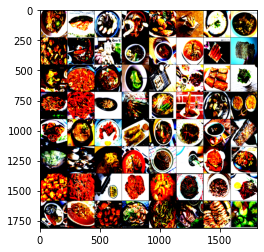

tensor([ 56, 115, 106,  98, 114,  22,  74, 118, 114, 127, 122, 106,  34, 118,
         53,  38,   4, 108,  30,  89, 100, 129,   5,  85, 112,  43,  97, 120,
        116,  22,  24, 124,  94,  74,  27,  98, 114, 104,  81,   5,  23, 109,
         23,  82,  94,  22,  28,  78,  31,  21,  77,  28,  29,  32,  33, 102,
         67,  27,  73,  56,  95, 111,  73,  89])


In [ ]:
def imshow(img):
  plt.imshow(np.transpose(img.numpy(), (1,2,0)))
  plt.show()

dataiter = iter(train_loader)
input = dataiter.next()
imshow(torchvision.utils.make_grid(input['image']))
print(input['label'])

# 4. Model Training (ResNet152)

In [24]:
# model
# model = models.resnet18().to(device)
model = models.resnet152().to(device)
model.load_state_dict(torch.load(os.path.join(path_root, 'predict','model','resnet152_last.pth')))

path_model_save = os.path.join(path_root, 'resnet152_final')

# loss & optimizer
learning_rate = .005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epochs = 5

In [ ]:
# training
best_acc = 0
best_model = model

for epoch in range(1, epochs + 1):
    model.train()
    for idx, input in enumerate(train_loader):
        images = input['image'].to(device)
        labels = input['label'].to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            progress = idx /(150000/batch_size) * 100
            print('Progress:',progress,'Loss:', loss.item())

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, epochs, loss.item()))
    
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for input in val_loader:
            images = input['image'].to(device)
            labels = input['label'].to(device)
         
           # Forward pass
            outputs = model(images)
            _, pred = torch.max(outputs.data, 1)
            total += len(labels)
            correct += (pred == labels).sum().item()
            
        acc = correct/total
        print('Epoch [{}/{}], Accuracy(validation set): {}'.format(epoch, epochs, acc))

    torch.save(model.state_dict(), path_model_save +'/resnet152_'+str(epoch)+'.pth')

    if acc > best_acc:
        best_acc = acc
        best_model = model

# save best model
torch.save(model.state_dict(), os.path.join(path_model_save, 'resnet152.pth'))

Progress: 0.0 Loss: 0.8794770836830139


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 0.4266666666666667 Loss: 0.7704336047172546
Progress: 0.8533333333333334 Loss: 0.6870959401130676
Progress: 1.28 Loss: 0.8760283589363098
Progress: 1.7066666666666668 Loss: 0.5599087476730347
Progress: 2.1333333333333333 Loss: 0.7237850427627563
Progress: 2.56 Loss: 0.7603262066841125
Progress: 2.986666666666667 Loss: 0.7887753844261169


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 3.4133333333333336 Loss: 1.093238353729248
Progress: 3.84 Loss: 0.855111837387085
Progress: 4.266666666666667 Loss: 0.6618818640708923


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 4.693333333333333 Loss: 0.7679276466369629


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 5.12 Loss: 1.039900541305542
Progress: 5.546666666666667 Loss: 0.7579557299613953
Progress: 5.973333333333334 Loss: 0.763360857963562
Progress: 6.4 Loss: 0.5661788582801819
Progress: 6.826666666666667 Loss: 0.808479905128479
Progress: 7.253333333333334 Loss: 0.7568545937538147
Progress: 7.68 Loss: 1.0028132200241089


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 8.106666666666666 Loss: 0.7725206613540649
Progress: 8.533333333333333 Loss: 0.7235585451126099
Progress: 8.959999999999999 Loss: 0.9068342447280884
Progress: 9.386666666666667 Loss: 0.9319292306900024
Progress: 9.813333333333334 Loss: 0.7447333335876465
Progress: 10.24 Loss: 1.270829200744629
Progress: 10.666666666666668 Loss: 1.2507082223892212


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 11.093333333333334 Loss: 0.49611619114875793
Progress: 11.52 Loss: 0.6645039319992065
Progress: 11.946666666666667 Loss: 0.7195526361465454
Progress: 12.373333333333333 Loss: 0.9416263103485107
Progress: 12.8 Loss: 0.8199746012687683
Progress: 13.226666666666667 Loss: 0.9020147323608398
Progress: 13.653333333333334 Loss: 0.8233034014701843
Progress: 14.08 Loss: 0.954133927822113
Progress: 14.506666666666668 Loss: 0.8067105412483215
Progress: 14.933333333333335 Loss: 0.7439665794372559
Progress: 15.36 Loss: 0.7841053009033203
Progress: 15.786666666666665 Loss: 0.906731128692627
Progress: 16.21333333333333 Loss: 0.7406399250030518
Progress: 16.64 Loss: 0.990693211555481
Progress: 17.066666666666666 Loss: 0.4295140504837036


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1498 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 17.493333333333332 Loss: 0.918663740158081
Progress: 17.919999999999998 Loss: 0.982907772064209
Progress: 18.346666666666668 Loss: 0.9126052260398865
Progress: 18.773333333333333 Loss: 0.753198504447937
Progress: 19.2 Loss: 0.6508200764656067
Progress: 19.62666666666667 Loss: 0.9347361922264099
Progress: 20.053333333333335 Loss: 0.8018040657043457
Progress: 20.48 Loss: 0.5711764693260193
Progress: 20.906666666666666 Loss: 0.6273882389068604
Progress: 21.333333333333336 Loss: 0.9327217936515808
Progress: 21.759999999999998 Loss: 0.46668630838394165
Progress: 22.186666666666667 Loss: 0.8822429776191711
Progress: 22.613333333333333 Loss: 0.7976899147033691
Progress: 23.04 Loss: 1.0273964405059814
Progress: 23.466666666666665 Loss: 0.7545888423919678
Progress: 23.893333333333334 Loss: 0.9055788516998291
Progress: 24.32 Loss: 0.9583738446235657
Progress: 24.746666666666666 Loss: 0.9639078974723816
Progress: 25.173333333333332 Loss: 0.5378649830818176
Progress: 25.6 Loss: 0.6271992

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1498 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 26.88 Loss: 0.8801372051239014
Progress: 27.30666666666667 Loss: 0.6302124261856079
Progress: 27.73333333333333 Loss: 1.0969245433807373
Progress: 28.16 Loss: 0.6423131227493286
Progress: 28.586666666666666 Loss: 1.0173285007476807
Progress: 29.013333333333335 Loss: 0.8189975619316101
Progress: 29.439999999999998 Loss: 1.179404854774475
Progress: 29.86666666666667 Loss: 0.8838223218917847
Progress: 30.293333333333333 Loss: 0.6510131359100342
Progress: 30.72 Loss: 0.8371947407722473
Progress: 31.14666666666667 Loss: 0.8674917221069336
Progress: 31.57333333333333 Loss: 0.9176878929138184
Progress: 32.0 Loss: 0.800150990486145
Progress: 32.42666666666666 Loss: 1.24068021774292


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 32.85333333333333 Loss: 0.8535612225532532
Progress: 33.28 Loss: 1.0125763416290283
Progress: 33.70666666666667 Loss: 0.9923645853996277
Progress: 34.13333333333333 Loss: 0.7928866744041443
Progress: 34.56 Loss: 0.967656672000885
Progress: 34.986666666666665 Loss: 1.0265790224075317
Progress: 35.413333333333334 Loss: 1.2034026384353638
Progress: 35.839999999999996 Loss: 0.9707784652709961
Progress: 36.266666666666666 Loss: 1.0071529150009155
Progress: 36.693333333333335 Loss: 0.6771531105041504
Progress: 37.12 Loss: 0.9479302763938904
Progress: 37.54666666666667 Loss: 0.6319143176078796
Progress: 37.97333333333333 Loss: 1.2972946166992188
Progress: 38.4 Loss: 0.8867666125297546
Progress: 38.82666666666667 Loss: 0.9779963493347168
Progress: 39.25333333333334 Loss: 0.9742989540100098
Progress: 39.68 Loss: 0.8133587837219238
Progress: 40.10666666666667 Loss: 0.7342197895050049
Progress: 40.53333333333333 Loss: 0.7814273834228516
Progress: 40.96 Loss: 0.832776665687561
Progress: 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


Progress: 41.81333333333333 Loss: 0.9187007546424866
Progress: 42.24 Loss: 0.7988619804382324
Progress: 42.66666666666667 Loss: 1.2011927366256714
Progress: 43.093333333333334 Loss: 1.079655408859253
Progress: 43.519999999999996 Loss: 0.9639110565185547
Progress: 43.946666666666665 Loss: 0.926365077495575
Progress: 44.373333333333335 Loss: 0.7425216436386108
Progress: 44.800000000000004 Loss: 1.0679576396942139
Progress: 45.22666666666667 Loss: 0.9691963195800781
Progress: 45.653333333333336 Loss: 0.7154545783996582
Progress: 46.08 Loss: 0.5850459933280945
Progress: 46.50666666666667 Loss: 0.8926023244857788
Progress: 46.93333333333333 Loss: 0.6252956390380859
Progress: 47.36 Loss: 1.0826644897460938
Progress: 47.78666666666667 Loss: 1.253203272819519
Progress: 48.21333333333334 Loss: 1.051882266998291
Progress: 48.64 Loss: 1.052391767501831
Progress: 49.06666666666666 Loss: 0.8415339589118958
Progress: 49.49333333333333 Loss: 0.5698918104171753
Progress: 49.919999999999995 Loss: 0.828

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 55.89333333333333 Loss: 1.0339003801345825
Progress: 56.32 Loss: 1.062842845916748
Progress: 56.74666666666667 Loss: 0.9408608675003052
Progress: 57.17333333333333 Loss: 1.1754792928695679
Progress: 57.599999999999994 Loss: 0.8121497631072998
Progress: 58.02666666666667 Loss: 0.7922910451889038
Progress: 58.45333333333333 Loss: 0.8393635153770447
Progress: 58.879999999999995 Loss: 0.8939785361289978
Progress: 59.306666666666665 Loss: 0.8018975853919983
Progress: 59.73333333333334 Loss: 0.8626566529273987
Progress: 60.160000000000004 Loss: 0.8866485357284546
Progress: 60.586666666666666 Loss: 1.109830379486084
Progress: 61.01333333333333 Loss: 0.9491269588470459
Progress: 61.44 Loss: 0.7672325372695923
Progress: 61.86666666666667 Loss: 0.6698846220970154
Progress: 62.29333333333334 Loss: 0.7470301389694214
Progress: 62.72 Loss: 0.5991348028182983
Progress: 63.14666666666666 Loss: 0.7055766582489014
Progress: 63.57333333333334 Loss: 0.6289682388305664
Progress: 64.0 Loss: 1.087

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1498 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 65.70666666666666 Loss: 0.664535403251648
Progress: 66.13333333333333 Loss: 0.8575335741043091
Progress: 66.56 Loss: 0.7377750873565674
Progress: 66.98666666666668 Loss: 0.8444196581840515
Progress: 67.41333333333334 Loss: 0.755064845085144
Progress: 67.84 Loss: 1.0800352096557617
Progress: 68.26666666666667 Loss: 0.8939942121505737


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 37386
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 37396
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


Progress: 68.69333333333333 Loss: 0.8506529331207275


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 37386
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 37396
  " Skipping tag %s" % (size, len(data), tag)


Progress: 69.12 Loss: 1.1009150743484497
Progress: 69.54666666666667 Loss: 0.5872542858123779
Progress: 69.97333333333333 Loss: 1.0258995294570923
Progress: 70.39999999999999 Loss: 0.9923484325408936
Progress: 70.82666666666667 Loss: 0.6700354814529419
Progress: 71.25333333333333 Loss: 0.991707444190979
Progress: 71.67999999999999 Loss: 0.9574029445648193
Progress: 72.10666666666667 Loss: 0.5304075479507446
Progress: 72.53333333333333 Loss: 0.6039459705352783
Progress: 72.96000000000001 Loss: 1.0586152076721191
Progress: 73.38666666666667 Loss: 0.9251894950866699
Progress: 73.81333333333333 Loss: 0.9604529142379761
Progress: 74.24 Loss: 0.68370121717453
Progress: 74.66666666666667 Loss: 1.198760747909546
Progress: 75.09333333333333 Loss: 1.0762574672698975
Progress: 75.52 Loss: 0.694666862487793
Progress: 75.94666666666666 Loss: 0.8099342584609985
Progress: 76.37333333333333 Loss: 0.8582187294960022
Progress: 76.8 Loss: 0.7318906784057617
Progress: 77.22666666666666 Loss: 0.88868230581

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 6. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)


Progress: 89.17333333333333 Loss: 0.849579930305481
Progress: 89.60000000000001 Loss: 0.5925958156585693


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


Progress: 90.02666666666667 Loss: 0.7365320920944214
Progress: 90.45333333333333 Loss: 1.0283902883529663
Progress: 90.88000000000001 Loss: 0.8458229303359985
Progress: 91.30666666666667 Loss: 1.0125796794891357
Progress: 91.73333333333333 Loss: 1.0787789821624756
Progress: 92.16 Loss: 1.0906378030776978
Progress: 92.58666666666666 Loss: 0.8140857815742493
Progress: 93.01333333333334 Loss: 0.8213415741920471
Progress: 93.44 Loss: 1.2015348672866821
Progress: 93.86666666666666 Loss: 0.7509536147117615
Progress: 94.29333333333332 Loss: 1.0102944374084473
Progress: 94.72 Loss: 0.834102213382721
Progress: 95.14666666666668 Loss: 0.9183956980705261
Epoch [1/5], Loss: 0.8987


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [1/5], Accuracy(validation set): 0.6430278884462152
Progress: 0.0 Loss: 0.6445655822753906
Progress: 0.4266666666666667 Loss: 0.44252878427505493
Progress: 0.8533333333333334 Loss: 0.4206081032752991
Progress: 1.28 Loss: 0.6744769811630249


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 1.7066666666666668 Loss: 0.6968375444412231
Progress: 2.1333333333333333 Loss: 0.6417803764343262
Progress: 2.56 Loss: 0.5451232194900513
Progress: 2.986666666666667 Loss: 0.6417028903961182
Progress: 3.4133333333333336 Loss: 1.1497459411621094
Progress: 3.84 Loss: 0.8510316610336304


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 4.266666666666667 Loss: 0.8129387497901917


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 4.693333333333333 Loss: 0.719088077545166
Progress: 5.12 Loss: 0.6268922686576843
Progress: 5.546666666666667 Loss: 0.6546118259429932
Progress: 5.973333333333334 Loss: 0.6401900053024292
Progress: 6.4 Loss: 1.1095982789993286
Progress: 6.826666666666667 Loss: 0.8300069570541382
Progress: 7.253333333333334 Loss: 1.0087025165557861
Progress: 7.68 Loss: 0.7806306481361389
Progress: 8.106666666666666 Loss: 0.6959302425384521
Progress: 8.533333333333333 Loss: 0.6062115430831909
Progress: 8.959999999999999 Loss: 0.8834064602851868
Progress: 9.386666666666667 Loss: 0.7202248573303223
Progress: 9.813333333333334 Loss: 0.7606183886528015
Progress: 10.24 Loss: 0.8619754910469055
Progress: 10.666666666666668 Loss: 0.9836052060127258


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 11.093333333333334 Loss: 0.4556891620159149
Progress: 11.52 Loss: 0.6547072529792786
Progress: 11.946666666666667 Loss: 0.6762175559997559
Progress: 12.373333333333333 Loss: 0.7270075678825378
Progress: 12.8 Loss: 0.5766928791999817


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 6. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)


Progress: 13.226666666666667 Loss: 0.5814123749732971
Progress: 13.653333333333334 Loss: 0.9964303970336914
Progress: 14.08 Loss: 0.5713028311729431
Progress: 14.506666666666668 Loss: 0.6259081959724426
Progress: 14.933333333333335 Loss: 0.8146519064903259
Progress: 15.36 Loss: 0.8473404049873352
Progress: 15.786666666666665 Loss: 0.6893451809883118
Progress: 16.21333333333333 Loss: 0.5801423192024231
Progress: 16.64 Loss: 0.8524883389472961


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 17.066666666666666 Loss: 0.6057559251785278
Progress: 17.493333333333332 Loss: 0.6404236555099487
Progress: 17.919999999999998 Loss: 0.8239107728004456
Progress: 18.346666666666668 Loss: 0.6126242876052856
Progress: 18.773333333333333 Loss: 0.48554447293281555
Progress: 19.2 Loss: 0.5473529696464539
Progress: 19.62666666666667 Loss: 0.5130929350852966
Progress: 20.053333333333335 Loss: 0.8215665221214294
Progress: 20.48 Loss: 0.6884406208992004
Progress: 20.906666666666666 Loss: 0.8788220286369324
Progress: 21.333333333333336 Loss: 0.682952880859375
Progress: 21.759999999999998 Loss: 0.8425199389457703
Progress: 22.186666666666667 Loss: 0.5637338757514954
Progress: 22.613333333333333 Loss: 1.1215555667877197
Progress: 23.04 Loss: 0.5865972638130188
Progress: 23.466666666666665 Loss: 0.6324762105941772
Progress: 23.893333333333334 Loss: 0.8312698006629944
Progress: 24.32 Loss: 0.9184149503707886
Progress: 24.746666666666666 Loss: 0.8384680151939392
Progress: 25.173333333333332

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 30.72 Loss: 0.5309357047080994
Progress: 31.14666666666667 Loss: 0.5773430466651917
Progress: 31.57333333333333 Loss: 0.9695255756378174


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 32.0 Loss: 0.6779060363769531
Progress: 32.42666666666666 Loss: 0.8509897589683533
Progress: 32.85333333333333 Loss: 0.7040517926216125
Progress: 33.28 Loss: 0.7036195993423462
Progress: 33.70666666666667 Loss: 0.6758994460105896
Progress: 34.13333333333333 Loss: 0.8698204159736633
Progress: 34.56 Loss: 0.744243323802948
Progress: 34.986666666666665 Loss: 0.5820291638374329
Progress: 35.413333333333334 Loss: 0.4016721248626709
Progress: 35.839999999999996 Loss: 0.6040452718734741
Progress: 36.266666666666666 Loss: 0.706371545791626
Progress: 36.693333333333335 Loss: 0.8201354742050171
Progress: 37.12 Loss: 0.9112560749053955
Progress: 37.54666666666667 Loss: 0.7189348340034485
Progress: 37.97333333333333 Loss: 0.6317353248596191
Progress: 38.4 Loss: 0.6166960000991821
Progress: 38.82666666666667 Loss: 0.85789954662323
Progress: 39.25333333333334 Loss: 0.3986223042011261
Progress: 39.68 Loss: 0.906810462474823
Progress: 40.10666666666667 Loss: 1.0580662488937378
Progress: 40.5

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1498 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 37386
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 

Progress: 42.24 Loss: 1.0159941911697388
Progress: 42.66666666666667 Loss: 0.7044591307640076
Progress: 43.093333333333334 Loss: 0.8189617991447449
Progress: 43.519999999999996 Loss: 0.9786704778671265
Progress: 43.946666666666665 Loss: 0.992703378200531
Progress: 44.373333333333335 Loss: 0.7068127989768982
Progress: 44.800000000000004 Loss: 0.7669413089752197
Progress: 45.22666666666667 Loss: 0.8308128714561462
Progress: 45.653333333333336 Loss: 0.8617911338806152
Progress: 46.08 Loss: 0.8635777235031128
Progress: 46.50666666666667 Loss: 0.7758004069328308
Progress: 46.93333333333333 Loss: 1.0055567026138306
Progress: 47.36 Loss: 0.5037268996238708
Progress: 47.78666666666667 Loss: 0.8717831373214722
Progress: 48.21333333333334 Loss: 0.7984340786933899
Progress: 48.64 Loss: 0.5955482721328735
Progress: 49.06666666666666 Loss: 1.0657306909561157
Progress: 49.49333333333333 Loss: 0.8067281246185303
Progress: 49.919999999999995 Loss: 0.5488089919090271
Progress: 50.346666666666664 Loss: 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 53.333333333333336 Loss: 0.6085445284843445
Progress: 53.76 Loss: 0.7445598244667053
Progress: 54.186666666666675 Loss: 0.6944741606712341
Progress: 54.61333333333334 Loss: 0.6843363642692566
Progress: 55.04 Loss: 0.6323855519294739
Progress: 55.46666666666666 Loss: 0.6853547096252441
Progress: 55.89333333333333 Loss: 0.7706335186958313
Progress: 56.32 Loss: 0.879485547542572
Progress: 56.74666666666667 Loss: 1.0910985469818115
Progress: 57.17333333333333 Loss: 0.5025364756584167
Progress: 57.599999999999994 Loss: 0.706388533115387
Progress: 58.02666666666667 Loss: 0.5542650818824768
Progress: 58.45333333333333 Loss: 0.54012131690979
Progress: 58.879999999999995 Loss: 0.6095027327537537
Progress: 59.306666666666665 Loss: 1.1301063299179077
Progress: 59.73333333333334 Loss: 0.7625299096107483
Progress: 60.160000000000004 Loss: 0.7328909635543823
Progress: 60.586666666666666 Loss: 0.7647491693496704
Progress: 61.01333333333333 Loss: 0.49685603380203247
Progress: 61.44 Loss: 0.6

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 71.25333333333333 Loss: 0.8016107678413391
Progress: 71.67999999999999 Loss: 1.0624529123306274
Progress: 72.10666666666667 Loss: 0.8410071730613708
Progress: 72.53333333333333 Loss: 0.8475227952003479
Progress: 72.96000000000001 Loss: 0.7056429982185364
Progress: 73.38666666666667 Loss: 1.1876050233840942
Progress: 73.81333333333333 Loss: 0.8841087222099304
Progress: 74.24 Loss: 0.6116031408309937
Progress: 74.66666666666667 Loss: 0.8427691459655762


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


Progress: 75.09333333333333 Loss: 0.8713202476501465


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 75.52 Loss: 0.9308165907859802
Progress: 75.94666666666666 Loss: 0.5856655836105347
Progress: 76.37333333333333 Loss: 0.8219992518424988
Progress: 76.8 Loss: 0.9901451468467712
Progress: 77.22666666666666 Loss: 0.7691593170166016
Progress: 77.65333333333334 Loss: 1.0528489351272583
Progress: 78.08 Loss: 1.0540467500686646
Progress: 78.50666666666667 Loss: 0.7845050096511841
Progress: 78.93333333333334 Loss: 1.023322582244873
Progress: 79.36 Loss: 0.7724851965904236
Progress: 79.78666666666666 Loss: 1.1638253927230835
Progress: 80.21333333333334 Loss: 1.4039041996002197
Progress: 80.64 Loss: 0.6355290412902832
Progress: 81.06666666666666 Loss: 0.776545524597168
Progress: 81.49333333333333 Loss: 0.647851288318634
Progress: 81.92 Loss: 0.7469993829727173
Progress: 82.34666666666666 Loss: 0.7324674725532532
Progress: 82.77333333333333 Loss: 0.9895128011703491
Progress: 83.2 Loss: 1.068757176399231
Progress: 83.62666666666667 Loss: 0.744402289390564
Progress: 84.05333333333334 Los

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 37386
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 37396
  " Skipping tag %s" % (size, len(data), tag)


Progress: 84.48 Loss: 0.7955134510993958
Progress: 84.90666666666667 Loss: 0.53957599401474
Progress: 85.33333333333334 Loss: 0.5458571314811707
Progress: 85.76 Loss: 0.9697859883308411
Progress: 86.18666666666667 Loss: 0.4200746417045593
Progress: 86.61333333333333 Loss: 0.6348953247070312
Progress: 87.03999999999999 Loss: 0.7815496921539307
Progress: 87.46666666666667 Loss: 0.8956488370895386
Progress: 87.89333333333333 Loss: 1.0917805433273315
Progress: 88.32 Loss: 0.9621387124061584
Progress: 88.74666666666667 Loss: 0.7359797954559326
Progress: 89.17333333333333 Loss: 0.7197847366333008


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 89.60000000000001 Loss: 0.9647523164749146
Progress: 90.02666666666667 Loss: 0.9854947924613953
Progress: 90.45333333333333 Loss: 1.1982604265213013
Progress: 90.88000000000001 Loss: 0.7902969121932983
Progress: 91.30666666666667 Loss: 0.9946718215942383
Progress: 91.73333333333333 Loss: 0.6932329535484314
Progress: 92.16 Loss: 0.6876172423362732
Progress: 92.58666666666666 Loss: 0.7582195401191711
Progress: 93.01333333333334 Loss: 0.9414557814598083
Progress: 93.44 Loss: 1.024872899055481
Progress: 93.86666666666666 Loss: 0.9877710342407227
Progress: 94.29333333333332 Loss: 0.6181502938270569
Progress: 94.72 Loss: 0.6814708113670349
Progress: 95.14666666666668 Loss: 0.662980318069458
Epoch [2/5], Loss: 0.7896


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [2/5], Accuracy(validation set): 0.6606905710491368
Progress: 0.0 Loss: 0.4992513060569763
Progress: 0.4266666666666667 Loss: 0.6928975582122803


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 0.8533333333333334 Loss: 0.7007356882095337


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 37386
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 37396
  " Skipping tag %s" % (size, len(data), tag)


Progress: 1.28 Loss: 0.7191137671470642
Progress: 1.7066666666666668 Loss: 0.9126371145248413
Progress: 2.1333333333333333 Loss: 0.5647392868995667
Progress: 2.56 Loss: 0.601747989654541
Progress: 2.986666666666667 Loss: 0.6756457090377808
Progress: 3.4133333333333336 Loss: 0.5389294624328613
Progress: 3.84 Loss: 0.7010117173194885
Progress: 4.266666666666667 Loss: 0.6202747821807861
Progress: 4.693333333333333 Loss: 0.8016548156738281
Progress: 5.12 Loss: 0.5405476689338684


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 5.546666666666667 Loss: 0.7226330041885376
Progress: 5.973333333333334 Loss: 0.6598030924797058
Progress: 6.4 Loss: 0.7767606973648071
Progress: 6.826666666666667 Loss: 0.4623871445655823


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 7.253333333333334 Loss: 0.8648531436920166


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1498 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 7.68 Loss: 0.4890541732311249
Progress: 8.106666666666666 Loss: 0.3076302409172058
Progress: 8.533333333333333 Loss: 0.7575939893722534
Progress: 8.959999999999999 Loss: 0.8956722021102905
Progress: 9.386666666666667 Loss: 0.45804885029792786
Progress: 9.813333333333334 Loss: 0.4456937611103058
Progress: 10.24 Loss: 0.7520471811294556
Progress: 10.666666666666668 Loss: 0.7547634840011597
Progress: 11.093333333333334 Loss: 0.544339120388031


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 11.52 Loss: 0.5838238596916199
Progress: 11.946666666666667 Loss: 0.8878527283668518
Progress: 12.373333333333333 Loss: 0.46934840083122253
Progress: 12.8 Loss: 0.633327066898346
Progress: 13.226666666666667 Loss: 0.7653891444206238
Progress: 13.653333333333334 Loss: 0.5537997484207153
Progress: 14.08 Loss: 0.5563368201255798
Progress: 14.506666666666668 Loss: 0.9936697483062744
Progress: 14.933333333333335 Loss: 0.5271854400634766
Progress: 15.36 Loss: 0.7427642345428467
Progress: 15.786666666666665 Loss: 0.7378823757171631
Progress: 16.21333333333333 Loss: 0.881608247756958


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 16.64 Loss: 0.5674901604652405
Progress: 17.066666666666666 Loss: 0.7182734608650208
Progress: 17.493333333333332 Loss: 0.8699162602424622
Progress: 17.919999999999998 Loss: 0.7646453380584717
Progress: 18.346666666666668 Loss: 0.5956002473831177
Progress: 18.773333333333333 Loss: 0.47593197226524353
Progress: 19.2 Loss: 0.8547340631484985
Progress: 19.62666666666667 Loss: 0.6950207948684692
Progress: 20.053333333333335 Loss: 0.6212334036827087
Progress: 20.48 Loss: 0.6091923713684082
Progress: 20.906666666666666 Loss: 0.7283561825752258
Progress: 21.333333333333336 Loss: 0.5899713039398193
Progress: 21.759999999999998 Loss: 0.7543273568153381


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 22.186666666666667 Loss: 0.644160270690918
Progress: 22.613333333333333 Loss: 0.5989270806312561
Progress: 23.04 Loss: 0.6343689560890198
Progress: 23.466666666666665 Loss: 0.890220582485199
Progress: 23.893333333333334 Loss: 0.6537826657295227
Progress: 24.32 Loss: 0.8469334840774536
Progress: 24.746666666666666 Loss: 0.6824426054954529
Progress: 25.173333333333332 Loss: 0.6258662939071655
Progress: 25.6 Loss: 0.7735255360603333
Progress: 26.026666666666664 Loss: 0.7579962015151978
Progress: 26.453333333333333 Loss: 0.6554006934165955
Progress: 26.88 Loss: 0.6981063485145569
Progress: 27.30666666666667 Loss: 0.8553711175918579
Progress: 27.73333333333333 Loss: 0.7431879043579102
Progress: 28.16 Loss: 0.89274001121521
Progress: 28.586666666666666 Loss: 0.9563729166984558
Progress: 29.013333333333335 Loss: 0.6262485980987549
Progress: 29.439999999999998 Loss: 0.7342655658721924
Progress: 29.86666666666667 Loss: 0.5371864438056946
Progress: 30.293333333333333 Loss: 0.8464062809

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1498 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 33.70666666666667 Loss: 0.7889536619186401
Progress: 34.13333333333333 Loss: 0.6977600455284119
Progress: 34.56 Loss: 0.7173862457275391
Progress: 34.986666666666665 Loss: 0.5671980381011963
Progress: 35.413333333333334 Loss: 0.601324200630188
Progress: 35.839999999999996 Loss: 0.7890316247940063
Progress: 36.266666666666666 Loss: 1.0510599613189697
Progress: 36.693333333333335 Loss: 0.5567805171012878
Progress: 37.12 Loss: 0.5473501682281494
Progress: 37.54666666666667 Loss: 0.7597607970237732
Progress: 37.97333333333333 Loss: 0.7687904238700867
Progress: 38.4 Loss: 0.9247977137565613
Progress: 38.82666666666667 Loss: 1.078516960144043
Progress: 39.25333333333334 Loss: 0.5182955861091614
Progress: 39.68 Loss: 0.9274203777313232
Progress: 40.10666666666667 Loss: 0.7760136127471924
Progress: 40.53333333333333 Loss: 0.9208513498306274
Progress: 40.96 Loss: 1.152526617050171
Progress: 41.38666666666666 Loss: 0.5834993124008179
Progress: 41.81333333333333 Loss: 0.6112366318702698

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


Progress: 44.800000000000004 Loss: 1.0112248659133911
Progress: 45.22666666666667 Loss: 0.9735056161880493
Progress: 45.653333333333336 Loss: 0.9030176997184753
Progress: 46.08 Loss: 0.8715107440948486
Progress: 46.50666666666667 Loss: 0.4035433530807495
Progress: 46.93333333333333 Loss: 0.8113151788711548
Progress: 47.36 Loss: 0.8454626202583313
Progress: 47.78666666666667 Loss: 0.5298646092414856
Progress: 48.21333333333334 Loss: 0.844000518321991
Progress: 48.64 Loss: 0.9522978663444519
Progress: 49.06666666666666 Loss: 0.7733005285263062
Progress: 49.49333333333333 Loss: 0.6921234130859375
Progress: 49.919999999999995 Loss: 0.6111005544662476
Progress: 50.346666666666664 Loss: 0.699406623840332
Progress: 50.77333333333334 Loss: 0.7211126685142517


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 51.2 Loss: 0.710863471031189
Progress: 51.626666666666665 Loss: 0.7265303730964661
Progress: 52.05333333333333 Loss: 0.9455717206001282
Progress: 52.480000000000004 Loss: 0.5864558815956116
Progress: 52.906666666666666 Loss: 0.7635465860366821
Progress: 53.333333333333336 Loss: 0.5665764212608337
Progress: 53.76 Loss: 0.8171214461326599
Progress: 54.186666666666675 Loss: 0.6672134399414062
Progress: 54.61333333333334 Loss: 0.7050257325172424
Progress: 55.04 Loss: 0.799063503742218
Progress: 55.46666666666666 Loss: 0.9839982986450195
Progress: 55.89333333333333 Loss: 0.7310643792152405
Progress: 56.32 Loss: 0.5006639957427979
Progress: 56.74666666666667 Loss: 0.6150546669960022
Progress: 57.17333333333333 Loss: 0.8376984000205994
Progress: 57.599999999999994 Loss: 0.7861279845237732
Progress: 58.02666666666667 Loss: 0.6968886256217957
Progress: 58.45333333333333 Loss: 0.5532907843589783
Progress: 58.879999999999995 Loss: 0.8123307824134827
Progress: 59.306666666666665 Loss: 1.

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 61.44 Loss: 0.6532526016235352
Progress: 61.86666666666667 Loss: 0.9345986843109131
Progress: 62.29333333333334 Loss: 0.5816020369529724
Progress: 62.72 Loss: 1.0493766069412231
Progress: 63.14666666666666 Loss: 0.49580657482147217
Progress: 63.57333333333334 Loss: 0.7575452327728271
Progress: 64.0 Loss: 0.7088738083839417
Progress: 64.42666666666666 Loss: 0.8650103211402893
Progress: 64.85333333333332 Loss: 0.7435785531997681
Progress: 65.28 Loss: 0.8404639959335327
Progress: 65.70666666666666 Loss: 0.6960473656654358
Progress: 66.13333333333333 Loss: 0.8782498240470886
Progress: 66.56 Loss: 0.6939076781272888
Progress: 66.98666666666668 Loss: 0.8586329221725464
Progress: 67.41333333333334 Loss: 0.609299898147583
Progress: 67.84 Loss: 0.6634655594825745
Progress: 68.26666666666667 Loss: 0.8291211724281311


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 68.69333333333333 Loss: 0.7275794744491577
Progress: 69.12 Loss: 0.7672337889671326
Progress: 69.54666666666667 Loss: 0.7429375052452087
Progress: 69.97333333333333 Loss: 0.6971725821495056
Progress: 70.39999999999999 Loss: 0.6565683484077454
Progress: 70.82666666666667 Loss: 0.840461015701294
Progress: 71.25333333333333 Loss: 0.6813951134681702
Progress: 71.67999999999999 Loss: 0.7928336262702942
Progress: 72.10666666666667 Loss: 0.5421733856201172
Progress: 72.53333333333333 Loss: 0.6892678737640381
Progress: 72.96000000000001 Loss: 0.555180013179779
Progress: 73.38666666666667 Loss: 0.6700723767280579
Progress: 73.81333333333333 Loss: 0.5557688474655151
Progress: 74.24 Loss: 0.9978090524673462
Progress: 74.66666666666667 Loss: 0.6097502112388611
Progress: 75.09333333333333 Loss: 0.5648577809333801
Progress: 75.52 Loss: 0.7977771759033203
Progress: 75.94666666666666 Loss: 0.5720773935317993
Progress: 76.37333333333333 Loss: 0.4928031861782074
Progress: 76.8 Loss: 0.66129928

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 6. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)


Progress: 85.76 Loss: 0.6670117974281311
Progress: 86.18666666666667 Loss: 0.9706622958183289
Progress: 86.61333333333333 Loss: 0.573383092880249
Progress: 87.03999999999999 Loss: 0.6395989060401917
Progress: 87.46666666666667 Loss: 0.8897285461425781
Progress: 87.89333333333333 Loss: 0.43866676092147827


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 88.32 Loss: 0.39112111926078796
Progress: 88.74666666666667 Loss: 0.7724294066429138
Progress: 89.17333333333333 Loss: 0.7168130874633789
Progress: 89.60000000000001 Loss: 0.5311551094055176
Progress: 90.02666666666667 Loss: 1.0614032745361328
Progress: 90.45333333333333 Loss: 0.8867284059524536
Progress: 90.88000000000001 Loss: 0.6924851536750793
Progress: 91.30666666666667 Loss: 0.7044771313667297
Progress: 91.73333333333333 Loss: 0.652763307094574
Progress: 92.16 Loss: 0.5688709616661072
Progress: 92.58666666666666 Loss: 0.31794220209121704
Progress: 93.01333333333334 Loss: 0.5080747008323669


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


Progress: 93.44 Loss: 0.5150609016418457
Progress: 93.86666666666666 Loss: 0.5344879627227783
Progress: 94.29333333333332 Loss: 0.6176537275314331
Progress: 94.72 Loss: 0.6620268821716309
Progress: 95.14666666666668 Loss: 0.7144555449485779
Epoch [3/5], Loss: 0.9744


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [3/5], Accuracy(validation set): 0.6872509960159362
Progress: 0.0 Loss: 0.6847366094589233


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 0.4266666666666667 Loss: 0.5144823789596558
Progress: 0.8533333333333334 Loss: 0.6429399847984314
Progress: 1.28 Loss: 0.44740235805511475
Progress: 1.7066666666666668 Loss: 0.5374643206596375
Progress: 2.1333333333333333 Loss: 0.5064108371734619
Progress: 2.56 Loss: 0.7122618556022644
Progress: 2.986666666666667 Loss: 0.4502040445804596


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 3.4133333333333336 Loss: 0.41559502482414246
Progress: 3.84 Loss: 0.4793799817562103


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 37386
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 37396
  " Skipping tag %s" % (size, len(data), tag)


Progress: 4.266666666666667 Loss: 0.5361328125
Progress: 4.693333333333333 Loss: 0.4988291263580322
Progress: 5.12 Loss: 0.6054080724716187
Progress: 5.546666666666667 Loss: 0.5943490266799927
Progress: 5.973333333333334 Loss: 0.5211606621742249
Progress: 6.4 Loss: 0.6433202624320984
Progress: 6.826666666666667 Loss: 0.48939427733421326
Progress: 7.253333333333334 Loss: 0.5717183947563171
Progress: 7.68 Loss: 0.9021095633506775
Progress: 8.106666666666666 Loss: 0.4915597140789032
Progress: 8.533333333333333 Loss: 0.5359106659889221
Progress: 8.959999999999999 Loss: 0.40113767981529236


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 9.386666666666667 Loss: 0.6119371652603149
Progress: 9.813333333333334 Loss: 0.5322397351264954
Progress: 10.24 Loss: 0.20921829342842102
Progress: 10.666666666666668 Loss: 0.620732307434082
Progress: 11.093333333333334 Loss: 0.4119790494441986


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 11.52 Loss: 0.30185484886169434
Progress: 11.946666666666667 Loss: 0.7961263060569763
Progress: 12.373333333333333 Loss: 0.8127049803733826
Progress: 12.8 Loss: 0.6268936395645142
Progress: 13.226666666666667 Loss: 0.645420491695404
Progress: 13.653333333333334 Loss: 1.0286500453948975
Progress: 14.08 Loss: 0.5716202855110168
Progress: 14.506666666666668 Loss: 0.5218244791030884
Progress: 14.933333333333335 Loss: 0.4371696710586548
Progress: 15.36 Loss: 0.5411363244056702
Progress: 15.786666666666665 Loss: 0.4981357455253601
Progress: 16.21333333333333 Loss: 0.7259244918823242
Progress: 16.64 Loss: 0.426419198513031
Progress: 17.066666666666666 Loss: 0.5418634414672852
Progress: 17.493333333333332 Loss: 0.6839745044708252
Progress: 17.919999999999998 Loss: 0.4512180984020233
Progress: 18.346666666666668 Loss: 0.4052191972732544
Progress: 18.773333333333333 Loss: 0.4824765920639038
Progress: 19.2 Loss: 0.6696869134902954
Progress: 19.62666666666667 Loss: 0.3029056191444397
Pro

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 20.906666666666666 Loss: 0.6663497090339661
Progress: 21.333333333333336 Loss: 0.642818033695221
Progress: 21.759999999999998 Loss: 0.5297684073448181
Progress: 22.186666666666667 Loss: 0.31358686089515686
Progress: 22.613333333333333 Loss: 0.6014100313186646
Progress: 23.04 Loss: 0.6276461482048035
Progress: 23.466666666666665 Loss: 0.42237961292266846
Progress: 23.893333333333334 Loss: 0.44634491205215454
Progress: 24.32 Loss: 0.7794449329376221
Progress: 24.746666666666666 Loss: 0.572625994682312


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 25.173333333333332 Loss: 0.684462308883667
Progress: 25.6 Loss: 0.6720098257064819
Progress: 26.026666666666664 Loss: 0.5471408367156982


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1498 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 26.453333333333333 Loss: 0.6063783764839172
Progress: 26.88 Loss: 0.441718190908432
Progress: 27.30666666666667 Loss: 0.5304169654846191
Progress: 27.73333333333333 Loss: 0.6513199806213379
Progress: 28.16 Loss: 0.42671653628349304
Progress: 28.586666666666666 Loss: 0.565228283405304
Progress: 29.013333333333335 Loss: 0.558927595615387
Progress: 29.439999999999998 Loss: 0.44433990120887756
Progress: 29.86666666666667 Loss: 0.6524207592010498


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Progress: 30.293333333333333 Loss: 0.6802548766136169
Progress: 30.72 Loss: 0.4941212832927704
Progress: 31.14666666666667 Loss: 0.8143357634544373
Progress: 31.57333333333333 Loss: 0.787222146987915
Progress: 32.0 Loss: 0.49275726079940796
Progress: 32.42666666666666 Loss: 0.3835795819759369
Progress: 32.85333333333333 Loss: 0.5038594603538513
Progress: 33.28 Loss: 0.6598300337791443
Progress: 33.70666666666667 Loss: 0.5757879614830017
Progress: 34.13333333333333 Loss: 0.35388246178627014


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1498 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Progress: 34.56 Loss: 0.8906245827674866
Progress: 34.986666666666665 Loss: 0.665857195854187
Progress: 35.413333333333334 Loss: 0.6373845338821411
Progress: 35.839999999999996 Loss: 0.7656325101852417
Progress: 36.266666666666666 Loss: 0.6844792366027832
Progress: 36.693333333333335 Loss: 0.4717670977115631
Progress: 37.12 Loss: 0.6611247062683105
Progress: 37.54666666666667 Loss: 0.6224231123924255
Progress: 37.97333333333333 Loss: 0.9238809943199158
Progress: 38.4 Loss: 0.5337372422218323
Progress: 38.82666666666667 Loss: 0.6759796738624573
Progress: 39.25333333333334 Loss: 0.4637133479118347
Progress: 39.68 Loss: 0.5973687767982483
Progress: 40.10666666666667 Loss: 0.5591831207275391
Progress: 40.53333333333333 Loss: 0.4846700131893158
Progress: 40.96 Loss: 0.6664949655532837
Progress: 41.38666666666666 Loss: 0.8441880345344543


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Progress: 41.81333333333333 Loss: 0.5677924156188965
Progress: 42.24 Loss: 0.845125138759613
Progress: 42.66666666666667 Loss: 0.5152923464775085
Progress: 43.093333333333334 Loss: 0.7103058695793152
Progress: 43.519999999999996 Loss: 0.7408485412597656
Progress: 43.946666666666665 Loss: 0.49959006905555725
Progress: 44.373333333333335 Loss: 0.5278058648109436
Progress: 44.800000000000004 Loss: 0.8875057101249695
Progress: 45.22666666666667 Loss: 0.8931427597999573
Progress: 45.653333333333336 Loss: 0.8210875391960144
Progress: 46.08 Loss: 0.4243882894515991
Progress: 46.50666666666667 Loss: 0.543786883354187
Progress: 46.93333333333333 Loss: 0.5872171521186829
Progress: 47.36 Loss: 0.6684735417366028
Progress: 47.78666666666667 Loss: 0.6092717051506042
Progress: 48.21333333333334 Loss: 0.571310818195343
Progress: 48.64 Loss: 0.5549041628837585
Progress: 49.06666666666666 Loss: 0.79816073179245
Progress: 49.49333333333333 Loss: 0.5523576140403748
Progress: 49.919999999999995 Loss: 0.79

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


Progress: 63.57333333333334 Loss: 0.5460898280143738
Progress: 64.0 Loss: 0.6493017077445984
Progress: 64.42666666666666 Loss: 0.9823061227798462
Progress: 64.85333333333332 Loss: 1.1568868160247803
Progress: 65.28 Loss: 0.703450083732605
Progress: 65.70666666666666 Loss: 0.5876259803771973
Progress: 66.13333333333333 Loss: 0.7273232340812683
Progress: 66.56 Loss: 0.6498099565505981
Progress: 66.98666666666668 Loss: 0.5737159848213196
Progress: 67.41333333333334 Loss: 0.8458277583122253


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


Progress: 67.84 Loss: 0.6239417791366577
Progress: 68.26666666666667 Loss: 0.9198784232139587
Progress: 68.69333333333333 Loss: 0.6037044525146484
Progress: 69.12 Loss: 0.714918315410614
Progress: 69.54666666666667 Loss: 0.3773312568664551
Progress: 69.97333333333333 Loss: 0.8201887607574463
Progress: 70.39999999999999 Loss: 0.8580129742622375
Progress: 70.82666666666667 Loss: 0.6397017240524292
Progress: 71.25333333333333 Loss: 0.6580255031585693
Progress: 71.67999999999999 Loss: 0.8868222236633301
Progress: 72.10666666666667 Loss: 0.7132628560066223
Progress: 72.53333333333333 Loss: 0.39916494488716125
Progress: 72.96000000000001 Loss: 0.6856750845909119
Progress: 73.38666666666667 Loss: 0.8550773859024048
Progress: 73.81333333333333 Loss: 0.6512786746025085
Progress: 74.24 Loss: 0.5641246438026428
Progress: 74.66666666666667 Loss: 0.8277119994163513
Progress: 75.09333333333333 Loss: 0.4578813314437866
Progress: 75.52 Loss: 0.49557673931121826
Progress: 75.94666666666666 Loss: 0.6026

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 37386
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 37396
  " Skipping tag %s" % (size, len(data), tag)


Progress: 76.37333333333333 Loss: 0.857052743434906
Progress: 76.8 Loss: 0.7431680560112
Progress: 77.22666666666666 Loss: 0.8633947968482971
Progress: 77.65333333333334 Loss: 0.45511394739151
Progress: 78.08 Loss: 0.6268317699432373
Progress: 78.50666666666667 Loss: 0.6381453275680542
Progress: 78.93333333333334 Loss: 0.7995173335075378
Progress: 79.36 Loss: 0.49299049377441406
Progress: 79.78666666666666 Loss: 0.6090654134750366
Progress: 80.21333333333334 Loss: 0.5029181241989136
Progress: 80.64 Loss: 0.37224334478378296
Progress: 81.06666666666666 Loss: 0.576154887676239


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 6. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)


Progress: 81.49333333333333 Loss: 0.6741624474525452
Progress: 81.92 Loss: 0.6593624949455261
Progress: 82.34666666666666 Loss: 0.5645296573638916
Progress: 82.77333333333333 Loss: 0.6797518730163574
Progress: 83.2 Loss: 0.4715108573436737
Progress: 83.62666666666667 Loss: 0.9604663252830505
Progress: 84.05333333333334 Loss: 0.6551190614700317
Progress: 84.48 Loss: 0.5280281901359558
Progress: 84.90666666666667 Loss: 0.7458642721176147
Progress: 85.33333333333334 Loss: 0.4997149109840393
Progress: 85.76 Loss: 0.5416251420974731
Progress: 86.18666666666667 Loss: 0.5744876861572266
Progress: 86.61333333333333 Loss: 0.7000747323036194
Progress: 87.03999999999999 Loss: 0.47121840715408325
Progress: 87.46666666666667 Loss: 0.6185630559921265
Progress: 87.89333333333333 Loss: 0.7628809213638306
Progress: 88.32 Loss: 0.6447107791900635
Progress: 88.74666666666667 Loss: 0.6177458167076111
Progress: 89.17333333333333 Loss: 0.641666829586029
Progress: 89.60000000000001 Loss: 0.39713481068611145


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [4/5], Accuracy(validation set): 0.7062416998671979


FileNotFoundError: ignored


# 5. Model Training (ViT)

### Reference: [vit-pytorch](https://github.com/lucidrains/vit-pytorch) (MIT License)

In [ ]:
!pip install vit-pytorch

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# pip freeze --local > /content/gdrive/My\ Drive/colab_installed.txt

In [ ]:
from vit_pytorch import ViT

model = ViT(
      image_size = 224,
      patch_size = 32,
      num_classes = 150,
      dim = 1024,
      depth = 6,
      heads = 16,
      mlp_dim = 2048,
      dropout = .1,
      emb_dropout = .1
)

path_model_save = os.path.join(path_root, 'ViT')


In [ ]:
model = models.resnet152().to(device)
model.load_state_dict(torch.load(os.path.join(path_root, 'predict','model','resnet152.pth')))

path_model_save = os.path.join(path_root, 'resnet152_new')

# loss & optimizer
learning_rate = .005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epochs = 5

In [ ]:
# training
best_acc = 0
best_model = model

for epoch in range(1, epochs + 1):
    model.train()
    for idx, input in enumerate(train_loader):
        images = input['image'].to(device)
        labels = input['label'].to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            progress = idx /(150000/batch_size) * 100
            print('Progress:',progress,'Loss:', loss.item())

            if int(progress) % 10 == 0:
                torch.save(model.state_dict(), path_model_save +'/ViT_'+str(epoch)+'_'+str(int(progress/10))+'.pth')

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, epochs, loss.item()))
    
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for input in val_loader:
            images = input['image'].to(device)
            labels = input['label'].to(device)
         
           # Forward pass
            outputs = model(images)
            _, pred = torch.max(outputs.data, 1)
            total += len(labels)
            correct += (pred == labels).sum().item()
            
        acc = correct/total
        print('Epoch [{}/{}], Accuracy(validation set): {} %'.format(epoch, epochs, acc))

    torch.save(model.state_dict(), path_model_save +'/ViT_'+str(epoch)+'.pth')

    if acc > best_acc:
        best_acc = acc
        best_model = model

# save best model
torch.save(model.state_dict(), os.path.join(path_model_save, 'ViT.pth'))